In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from config import census_key
import json
import requests 
#from census import Census


In [2]:
# Import Accident dataset

accident_data = pd.read_csv(r'usaccidents.csv')


# Drop unnecessary columns
reduced_accident_df = accident_data[["ID", "Severity", "Start_Time", "Start_Lat", "Start_Lng", "Street", "County", "State", "Zipcode", 
                                     "Weather_Timestamp", "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", 
                                     "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)", "Precipitation(in)", "Weather_Condition"]]
# create df
df = pd.DataFrame(reduced_accident_df)

# Convert dates(object) to integers
df['Start_Time'] = pd.to_datetime(df['Start_Time'])

df['Start_Time'] = df['Start_Time'].apply(lambda x: x.date())

#add to df
df['Start_Time'] = pd.to_datetime(df['Start_Time'])


In [3]:
# Limit data to two-year period

start_date = "2017-01-01"
end_date = "2019-12-31"

mask = (df['Start_Time'] > start_date) & (df['Start_Time'] <= end_date)
two_year_df = df.loc[mask]
#two_year_df


In [4]:
# convert date field to integer and use for join field
new_dates = two_year_df['Start_Time'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)

two_year_df['AccidentJoin'] = new_dates

# rename dataframe
accident_2_df = two_year_df
accident_2_df.head()

C:\Users\Matt\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ID,Severity,Start_Time,Start_Lat,Start_Lng,Street,County,State,Zipcode,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,AccidentJoin
9217,A-9218,2,2017-01-02,38.234737,-122.664314,Bodega Ave,Sonoma,CA,94952-1748,2017-01-02 14:15:00,46.4,45.2,76.0,30.02,10.0,NNW,3.5,NaN,Overcast,20170102
9218,A-9219,2,2017-01-02,38.246796,-122.627808,E Washington St,Sonoma,CA,94952,2017-01-02 14:15:00,46.4,45.2,76.0,30.02,10.0,NNW,3.5,NaN,Overcast,20170102
9219,A-9220,2,2017-01-02,38.192196,-122.543053,Old Lakeville No 2 Rd,Sonoma,CA,94954,2017-01-02 14:35:00,46.4,45.2,81.0,30.03,10.0,NW,3.5,NaN,Overcast,20170102
9220,A-9221,3,2017-01-02,37.732292,-122.414909,I-280 S,San Francisco,CA,94110,2017-01-02 12:56:00,52.0,NaN,61.0,30.02,10.0,SSW,15.0,NaN,Overcast,20170102
9221,A-9222,3,2017-01-02,38.211773,-122.144753,I-80 E,Solano,CA,94534,2017-01-02 14:54:00,52.0,NaN,66.0,29.98,10.0,SW,12.7,NaN,Mostly Cloudy,20170102


In [5]:
# County data for Ohio
url = "https://api.census.gov/data/2010/dec/sf1?get=P001001,NAME&for=county:*&key="

# Build query URL
query_url = url + census_key

census_response = requests.get(query_url)
census_json = census_response.json()

census_county_pd = pd.DataFrame(census_json)

# Split county name from state

# new data frame with split value columns 
new = census_county_pd[1].str.split(", ", n = 1, expand = True) 
  
# making separate county column from new data frame 
census_county_pd["County"]= new[0] 
  
# making separate state column from new data frame 
census_county_pd["State"]= new[1] 
  
# Dropping old Name columns 
census_county_pd.drop(columns =[1], inplace = True) 

# # Drop column labels
census_county_pd = census_county_pd.drop([census_county_pd.index[0]])

# split county column - remove the word County
new2 = census_county_pd["County"].str.split(" ", n = 1, expand = True) 

# making separate county column from new data frame 
census_county_pd["County"]= new2[0] 
  
# making separate state column from new data frame 
census_county_pd["Garbage"]= new2[1] 

# Drop extra columns
census_county_pd.drop(columns =[2], inplace = True)
census_county_pd.drop(columns =[3], inplace = True)
census_county_pd.drop(columns =["Garbage"], inplace = True)

# # filter down to state of ohio
ohio_county = census_county_pd.loc[(census_county_pd['State'] == "Ohio")]

# # rename columns
ohio_county.columns = ['Pop', 'County', 'State']


# # rearrange columns
ohio_county = ohio_county[['County', 'State', 'Pop']]



In [6]:
# read ohio square miles county csv
square_mile = pd.read_csv(r'ohiosquaremilescounty.csv')

# Merge square miles of each county into ohio_county df
ohio_sqmile_df=ohio_county.merge(square_mile,how='left', left_on='County', right_on='County')

#convert population to int
ohio_sqmile_df['Pop'] = ohio_sqmile_df['Pop'].astype(int)

# Calculate population density and add to dataframe
pop_den = ohio_sqmile_df["Pop"]/ohio_sqmile_df["SqMiles"]

ohio_sqmile_df["PopDensity"] = pop_den



In [7]:
# Filter down accident df to only Ohio
#accident_ohio = accident_holiday_df.loc[(accident_holiday_df['State']=='OH')]
accident_ohio = accident_2_df.loc[(accident_2_df['State']=='OH')]

weather_ohio = accident_ohio

# get accident count by County
ohio_acc = accident_ohio.groupby(["County"]).count()["ID"]

#create df
ohio_acc_df = pd.DataFrame({"Accidents": ohio_acc})

#reset index
ohio_acc_df = ohio_acc_df.reset_index(drop=False)

# sort data
ohio_acc_df = ohio_acc_df.sort_values("Accidents", ascending=False)

ohio_acc_df

,County,Accidents
24,Franklin,10028
55,Montgomery,9285
30,Hamilton,6242
17,Cuyahoga,5738
20,Delaware,2297
...,...,...
40,Jefferson,7
59,Noble,6
32,Hardin,6
26,Gallia,5


In [8]:
# merge county population density with accident dataframe

accident_ohio_county = ohio_acc_df.merge(ohio_sqmile_df,how='left', left_on='County', right_on='County')


pop_density = accident_ohio_county[["County", "Accidents", "PopDensity"]]

# create df
pop_density_df = pd.DataFrame(pop_density)

# rearrange columns
pop_density_df = pop_density_df[['County', 'PopDensity', 'Accidents']]

# sort data
pop_density_df = pop_density_df.sort_values("PopDensity", ascending=False)

# take top 15
ohio_pop = pop_density_df.head(15)

ohio_pop

,County,PopDensity,Accidents
3,Cuyahoga,2799.978127,5738
0,Franklin,2186.087675,10028
2,Hamilton,1976.728832,6242
5,Summit,1312.612962,2168
6,Lucas,1296.177316,1276
1,Montgomery,1159.469180,9285
20,Lake,1011.213680,162
7,Butler,788.185672,598
16,Stark,652.886471,197
17,Lorain,613.634698,194


In [9]:
# Set state as index
ohio_pop.set_index("County", inplace=True)

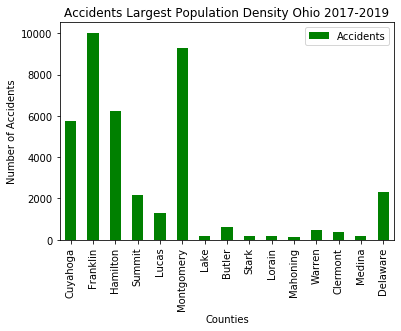

In [10]:
# Create bar graph most populated states
ohio_pop.plot(kind="bar", facecolor="Green", y="Accidents")

# Give the chart a title, x label, and y label
plt.title("Accidents Largest Population Density Ohio 2017-2019")
plt.xlabel("Counties")
plt.ylabel("Number of Accidents")
plt.show

plt.savefig("../ProjectOneTeam5/output/11OhioDenslyPopulatedGraph.png", bbox_inches = "tight")


In [11]:
# Ohio Weather Conditions

weather_ohio.head()

,ID,Severity,Start_Time,Start_Lat,Start_Lng,Street,County,State,Zipcode,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,AccidentJoin
182192,A-182194,2,2017-01-09,41.722279,-83.536194,N Detroit Ave,Lucas,OH,43612,2017-01-09 07:34:00,19.9,10.1,61.0,30.37,10.0,South,8.1,NaN,Overcast,20170109
182287,A-182289,3,2017-01-10,41.721436,-83.501366,I-75 S,Lucas,OH,43612,2017-01-10 07:14:00,33.4,27.3,92.0,29.97,4.0,South,6.9,NaN,Light Snow,20170110
182438,A-182440,2,2017-01-11,41.727242,-83.524315,Stickney Ave,Lucas,OH,43612,2017-01-11 08:14:00,32.2,25.8,88.0,30.08,7.0,SSW,6.9,NaN,Clear,20170111
182439,A-182441,2,2017-01-11,41.715591,-83.506302,N Matzinger Rd,Lucas,OH,43612,2017-01-11 08:14:00,32.2,25.8,88.0,30.08,7.0,SSW,6.9,NaN,Clear,20170111
182725,A-182727,2,2017-01-16,41.728321,-83.493790,Rosemar Rd,Lucas,OH,43611-1013,2017-01-16 06:54:00,28.4,NaN,89.0,30.33,5.0,Calm,NaN,NaN,Overcast,20170116


In [12]:
# consolidate 60 weather types into 6 categories

#consolidate Clear
weather_ohio['Weather_Condition'] = weather_ohio['Weather_Condition'].replace(
    {'Fair': 'Clear', 'Fair / Windy': 'Clear'})

# consolidate Snow
weather_ohio['Weather_Condition'] = weather_ohio['Weather_Condition'].replace(
    {'Snow / Windy': 'Snow', 'Snow Showers': 'Snow', 'Squalls': 'Snow', 'Wintry Mix': 'Snow', 'Heavy Snow': 'Snow',
    'Light Freezing Drizzle': 'Snow', 'Light Freezing Rain': 'Snow', 'Light Freezing Rain / Windy': 'Snow',
    'Light Ice Pellets': 'Snow', 'Light Snow': 'Snow', 'Light Snow / Windy': 'Snow', 'Light Snow Grains': 'Snow',
    'Light Snow Showers': 'Snow', 'Light Snow and Sleet': 'Snow', 'Light Thunderstorms and Snow': 'Snow'})

#consolidate Thunderstorm
weather_ohio['Weather_Condition'] = weather_ohio['Weather_Condition'].replace(
    {'T-Storm': 'Thunderstorm', 'T-Storm / Windy': 'Thunderstorm', 'Thunder': 'Thunderstorm', 'Thunder / Windy': 'Thunderstorm',
    'Thunder in the Vicinity': 'Thunderstorm', 'Thunderstorms and Rain': 'Thunderstorm', 'Heavy Drizzle': 'Thunderstorm', 
    'Heavy Rain': 'Thunderstorm', 'Heavy Rain / Windy': 'Thunderstorm', 'Heavy T-Storm': 'Thunderstorm', 
    'Heavy Thunderstorms and Rain': 'Thunderstorm', 'Light Thunderstorm': 'Thunderstorm',
    'Light Thunderstorms and Rain': 'Thunderstorm'})

#consolidate Rain
weather_ohio['Weather_Condition'] = weather_ohio['Weather_Condition'].replace(
    {'Rain / Windy': 'Rain', 'Rain Showers': 'Rain', 'Drizzle': 'Rain', 'Light Drizzle': 'Rain',
    'Light Drizzle / Windy': 'Rain', 'Light Rain': 'Rain', 'Light Rain / Windy': 'Rain', 
    'Light Rain Shower': 'Rain', 'Light Rain Showers': 'Rain', 'Light Rain with Thunder': 'Rain'})

# consolidate Cloudy
weather_ohio['Weather_Condition'] = weather_ohio['Weather_Condition'].replace(
    {'Cloudy / Windy': 'Cloudy', 'Fog': 'Cloudy', 'Haze': 'Cloudy', 'Haze / Windy': 'Cloudy', 'Light Freezing Fog': 'Cloudy',
    'Mist': 'Cloudy', 'Mostly Cloudy': 'Cloudy', 'Mostly Cloudy / Windy': 'Cloudy',
    'Overcast': 'Cloudy', 'Partly Cloudy': 'Cloudy', 'Partly Cloudy / Windy': 'Cloudy', 'Patches of Fog': 'Cloudy',
    'Scattered Clouds': 'Cloudy', 'Shallow Fog': 'Cloudy', 'Small Hail': 'Cloudy'})



C:\Users\Matt\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Matt\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Matt\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [13]:
# get accident count by weather
ohio_weather = weather_ohio.groupby(["Weather_Condition"]).count()["ID"]

#create df
ohio_weather_df = pd.DataFrame({"Accidents": ohio_weather})

#reset index
ohio_weather_df = ohio_weather_df.reset_index(drop=False)

# sort data
ohio_weather_df = ohio_weather_df.sort_values("Accidents", ascending=False)

ohio_weather_df


,Weather_Condition,Accidents
1,Cloudy,23887
0,Clear,13220
3,Rain,4405
4,Snow,2278
5,Thunderstorm,501
2,N/A Precipitation,1


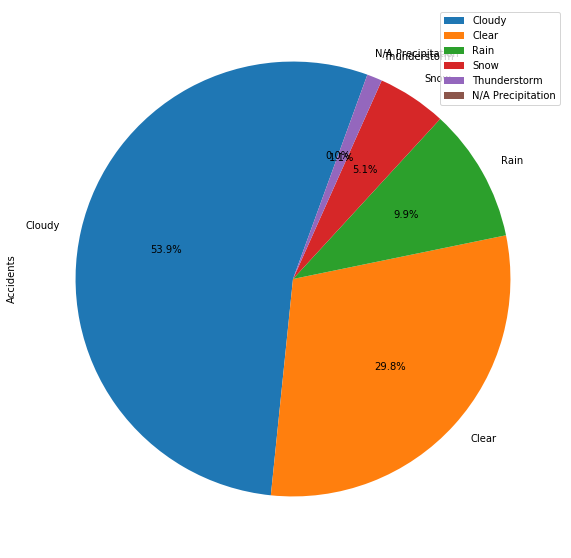

In [14]:
# Set weather condition as index
ohio_weather_df.set_index("Weather_Condition", inplace=True)


# create pie chart
plot = ohio_weather_df.plot.pie(y='Accidents', autopct='%1.1f%%', startangle=70, figsize=(10, 10))

plt.savefig("../ProjectOneTeam5/output/12Ohioweather.png", bbox_inches = "tight")
